<center><h1>Projeto 3 - Ciência dos Dados </h1></center>
<center><h5>Alexandre Zamberlan Filho</h5></center>
<center><h5>Caio Horschutz Fauza</h5></center>
<center><h5>Pedro Paulo Mendonça Telho</h5></center>
 

> <b>Tema:</b> Previsão da modalidade esportiva que um atleta, baseando-se em características pré-definidas, deve praticar.        
><b>Metodologia:</b> Clusterização   
><b>Dataset utilizado:</b> "120 years of Olympic History of athletes and results" (Kaggle) 

In [2]:
import pandas as pd
import numpy as np
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

geral = pd.read_csv("athlete_events.csv")

nclusters = len(geral["Sport"].value_counts())
sports = pd.unique(geral["Sport"]).tolist()

geraldados = geral.loc[:,("Age", "Height", "Weight")]
geraldados2 = geraldados[geral.Season == "Summer"]
dados = geraldados2.dropna()

med = cluster.MiniBatchKMeans(n_clusters= nclusters, random_state = 0)
med.fit(dados)
output = med.predict(dados)




array([34, 20, 39, ..., 14, 51, 39])

In [100]:
a = pd.Series(output)
a.value_counts()

3     6247
34    5060
14    5022
21    4885
41    4852
0     4817
9     4554
20    4302
1     3980
33    3912
25    3782
54    3781
11    3761
39    3720
51    3694
12    3633
47    3547
46    3522
16    3489
56    3478
27    3420
26    3414
30    3376
44    3258
35    3114
23    3037
10    3035
60    2837
40    2775
64    2596
      ... 
31    2152
36    2017
29    1967
8     1953
58    1937
65    1895
45    1889
52    1736
38    1731
22    1722
18    1706
62    1616
55    1605
50    1544
15    1505
28    1286
48    1174
42    1115
7     1044
37    1004
17    1001
24     776
57     674
61     633
63     513
6      490
32     365
4      271
19     182
43      38
Length: 66, dtype: int64

In [47]:
geral[geral.Name == "A Dijiang"]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN


In [52]:
geral["Sport"].value_counts()

Athletics                38624
Gymnastics               26707
Swimming                 23195
Shooting                 11448
Cycling                  10859
Fencing                  10735
Rowing                   10595
Cross Country Skiing      9133
Alpine Skiing             8829
Wrestling                 7154
Football                  6745
Sailing                   6586
Equestrianism             6344
Canoeing                  6171
Boxing                    6047
Speed Skating             5613
Ice Hockey                5516
Hockey                    5417
Biathlon                  4893
Basketball                4536
Weightlifting             3937
Water Polo                3846
Judo                      3801
Handball                  3665
Art Competitions          3578
Volleyball                3404
Bobsleigh                 3058
Tennis                    2862
Diving                    2842
Ski Jumping               2401
                         ...  
Badminton                 1457
Nordic C

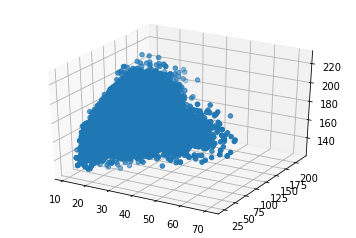

In [64]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection="3d")
plt3d.scatter(dados.Age, dados.Weight, dados.Height)